In [2]:
#importing the nescessary libraries for visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Different types of variables present in the datasets


* **Numerical vaiables**: Age, Fare, SibSp and Parch
* **Categorical variables:** Sex, Embarked, Survived and Pclass
* **Alphanumeric Variables**: Ticket and Cabin(Contains both alphabets and the numeric value)
* **Text Variables**: Name

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
print("Training data missing values \n" ,train_df.isnull().sum())
print("\n Test data missing values \n" ,test_df.isnull().sum())

Training data missing values 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

 Test data missing values 
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


<Axes: xlabel='Survived', ylabel='Fare'>

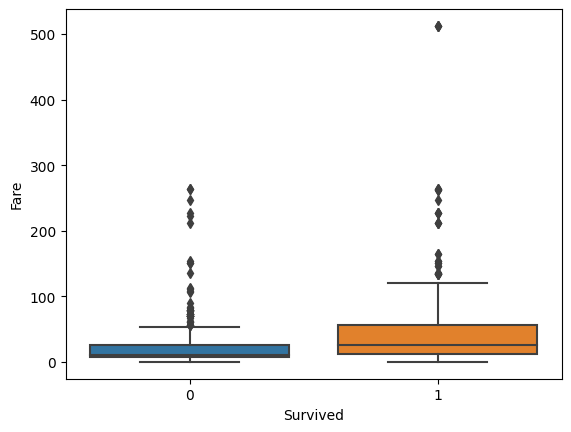

In [6]:
sns.boxplot(x='Survived',y='Fare',data=train_df)

* Age and Cabin have a lot of missing values - I will try to fill the age values using an estimator and will drop the cabin column as it has a lot of missing valus and randomly filling it might lead to wrong predictions.
* Passenger Id and Ticket number are not required to build the model so I will drop them.


In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import pandas as pd

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.imputer = SimpleImputer(strategy="mean")
    
    def fit(self, X, y=None):
        # Assuming X is a DataFrame and 'Age' is a column in X
        self.imputer.fit(X[['Age']])
        return self

    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X



In [8]:
import re
full_data = [train_df, test_df]

def get_title(name):
        title_search=re.search(' ([A-Za-z]+)\.',name)
        if title_search:
            return title_search.group(1)
        return ""
    
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
print(pd.crosstab(train_df['Title'], train_df['Sex']))



Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


* Now embark has three categorical variables C,S and Q. I will create three different columns as and keep them as binary numbers. This helps the learning models to better learn the data. I will do the same thing with male and female.

In [9]:
import re
from sklearn.preprocessing import OneHotEncoder
class FeatureEncoder(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        encoder= OneHotEncoder()
        
        matrix= encoder.fit_transform(X[['Embarked']]).toarray()
        column_names= ["C","S","Q","N"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
        
        matrix=encoder.fit_transform(X[['Sex']]).toarray()
        column_names=["Female","Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
            
        
            
        X['FamilySize']=X['SibSp']+X['Parch']+1
        X['isAlone']=0
        X.loc[X['FamilySize']==1, "isAlone"]=1
        
        #Title extraction and simplification
        X['Title'] = X['Name'].apply(self.get_title)
        X['Title'] = X['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 
                                         'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        X['Title'] = X['Title'].replace(['Mlle', 'Ms'], 'Miss')
        X['Title'] = X['Title'].replace('Mme', 'Mrs')
        
        matrix= encoder.fit_transform(X[['Title']]).toarray()
        #using the methpd to get all the unique titles rather than creating the columns manually
        unique_titles=encoder.get_feature_names_out(['Title'])
        for i, title in enumerate(unique_titles):
            X[title]=matrix[:,i]
            
        return X
    
    full_data = [train_df, test_df]
    
    @staticmethod
    def get_title(name):
            title_search=re.search(' ([A-Za-z]+)\.',name)
            if title_search:
                return title_search.group(1)
            return ""
    
    for dataset in full_data:
        dataset['Title'] = dataset['Name'].apply(get_title)
    


In [10]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N","Title","PassengerId","Parch","SibSp"],axis=1, errors="ignore")


In [11]:
from sklearn.pipeline import Pipeline

pipeline= Pipeline([("ageimputer",AgeImputer()),
                    ("featureencoder",FeatureEncoder()),
                    ("featuredropper",FeatureDropper())])

transformed_train_set=pipeline.fit_transform(train_df)
transformed_train_set

,Survived,Pclass,Age,Fare,C,S,Q,Female,Male,FamilySize,isAlone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,22.000000,7.2500,0.0,0.0,1.0,0.0,1.0,2,0,0.0,0.0,1.0,0.0,0.0
1,1,1,38.000000,71.2833,1.0,0.0,0.0,1.0,0.0,2,0,0.0,0.0,0.0,1.0,0.0
2,1,3,26.000000,7.9250,0.0,0.0,1.0,1.0,0.0,1,1,0.0,1.0,0.0,0.0,0.0
3,1,1,35.000000,53.1000,0.0,0.0,1.0,1.0,0.0,2,0,0.0,0.0,0.0,1.0,0.0
4,0,3,35.000000,8.0500,0.0,0.0,1.0,0.0,1.0,1,1,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,13.0000,0.0,0.0,1.0,0.0,1.0,1,1,0.0,0.0,0.0,0.0,1.0
887,1,1,19.000000,30.0000,0.0,0.0,1.0,1.0,0.0,1,1,0.0,1.0,0.0,0.0,0.0
888,0,3,29.699118,23.4500,0.0,0.0,1.0,1.0,0.0,4,0,0.0,1.0,0.0,0.0,0.0
889,1,1,26.000000,30.0000,1.0,0.0,0.0,0.0,1.0,1,1,0.0,0.0,1.0,0.0,0.0


**Exploratory Data Analysis**

In [12]:
transformed_train_set.groupby('Survived').mean()

,Pclass,Age,Fare,C,S,Q,Female,Male,FamilySize,isAlone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
Survived,,,,,,,,,,,,,,,
0,2.531876,30.415100,22.117887,0.136612,0.085610,0.777778,0.147541,0.852459,1.883424,0.681239,0.030965,0.100182,0.794171,0.047359,0.027322
1,1.950292,28.549778,48.395408,0.271930,0.087719,0.634503,0.681287,0.318713,1.938596,0.476608,0.067251,0.380117,0.236842,0.292398,0.023392


In [13]:
transformed_train_set.groupby(['Female','Male']).mean()

,,Survived,Pclass,Age,Fare,C,S,Q,FamilySize,isAlone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
Female,Male,,,,,,,,,,,,,,
0.0,1.0,0.188908,2.389948,30.505824,25.523893,0.164645,0.071057,0.764298,1.665511,0.712305,0.069324,0.000000,0.896014,0.000000,0.034662
1.0,0.0,0.742038,2.159236,28.216730,44.479818,0.232484,0.114650,0.646497,2.343949,0.401274,0.000000,0.589172,0.000000,0.401274,0.009554


In [14]:
transformed_train_set.corr()

,Survived,Pclass,Age,Fare,C,S,Q,Female,Male,FamilySize,isAlone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
Survived,1.000000,-0.338481,-0.069809,0.257307,0.168240,0.003650,-0.155660,0.543351,-0.543351,0.016639,-0.203367,0.085221,0.335636,-0.549199,0.341994,-0.012054
Pclass,-0.338481,1.000000,-0.331339,-0.549500,-0.243292,0.221009,0.081720,-0.131900,0.131900,0.065997,0.135207,0.082081,-0.010261,0.142698,-0.153758,-0.187174
Age,-0.069809,-0.331339,1.000000,0.091566,0.032024,-0.013855,-0.027121,-0.084153,0.084153,-0.248512,0.179775,-0.377265,-0.249169,0.185900,0.164533,0.189872
Fare,0.257307,-0.549500,0.091566,1.000000,0.269335,-0.117216,-0.166603,0.182333,-0.182333,0.217138,-0.271832,0.010908,0.119518,-0.183766,0.107259,0.016275
C,0.168240,-0.243292,0.032024,0.269335,1.000000,-0.148258,-0.778359,0.082853,-0.082853,-0.046215,-0.095298,-0.035225,0.036204,-0.072567,0.067872,0.030095
S,0.003650,0.221009,-0.013855,-0.117216,-0.148258,1.000000,-0.496624,0.074115,-0.074115,-0.058592,0.086464,0.010478,0.167531,-0.078338,-0.090432,0.000311
Q,-0.155660,0.081720,-0.027121,-0.166603,-0.778359,-0.496624,1.000000,-0.125722,0.125722,0.079977,0.024929,0.025291,-0.140414,0.118482,-0.007704,-0.025678
Female,0.543351,-0.131900,-0.084153,0.182333,0.082853,0.074115,-0.125722,1.000000,-1.000000,0.200988,-0.303646,-0.159934,0.693916,-0.867334,0.550146,-0.075638
Male,-0.543351,0.131900,0.084153,-0.182333,-0.082853,-0.074115,0.125722,-1.000000,1.000000,-0.200988,0.303646,0.159934,-0.693916,0.867334,-0.550146,0.075638
FamilySize,0.016639,0.065997,-0.248512,0.217138,-0.046215,-0.058592,0.079977,0.200988,-0.200988,1.000000,-0.690922,0.372472,0.107500,-0.338014,0.153842,-0.047426


Text(0.5, 1.0, 'Correlations Among Features')

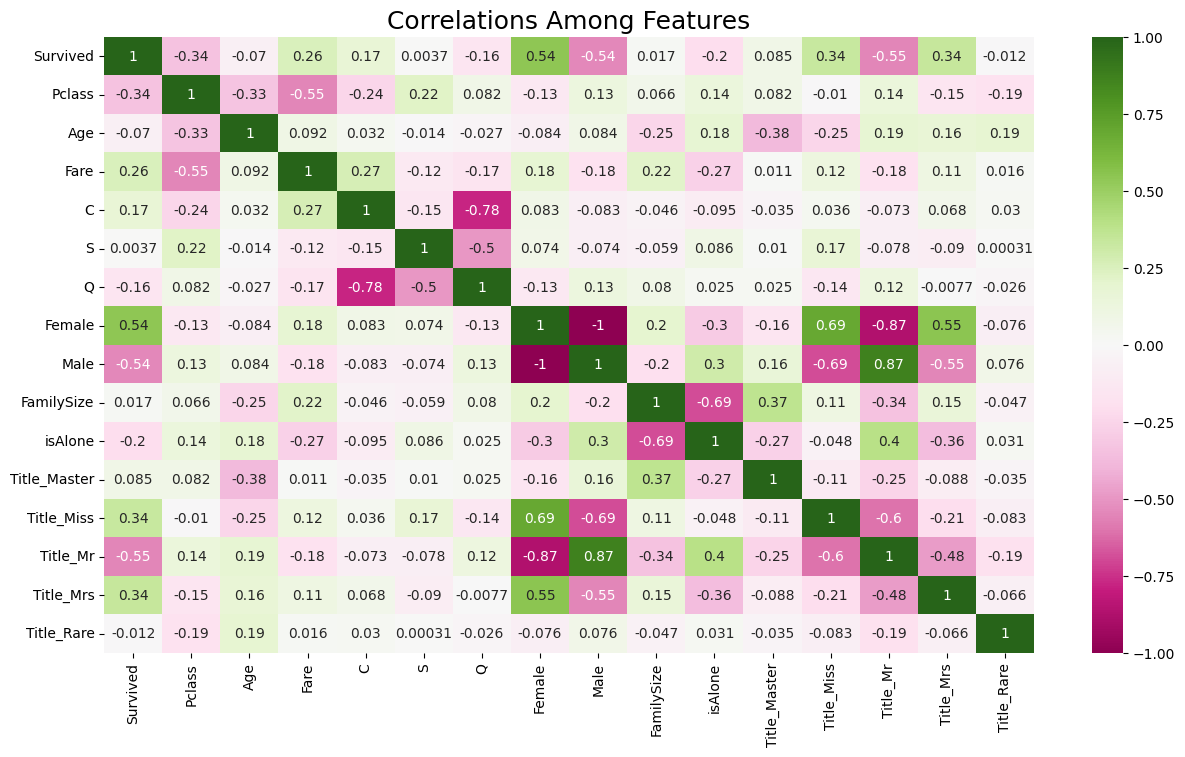

In [15]:
plt.subplots(figsize = (15,8))
sns.heatmap(transformed_train_set.corr(), annot=True,cmap="PiYG")
plt.title("Correlations Among Features", fontsize = 18)

Fare and Survived: 0.26.
There is a positive correlation between Fare and Survived rated. This means that, the passenger who paid more money for their ticket were more likely to survive.

/tmp/ipykernel_42/3167738809.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(transformed_train_set.loc[(transformed_train_set['Survived'] == 0),'Pclass'],shade=True,color='r',label='Not Survived')
/tmp/ipykernel_42/3167738809.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(transformed_train_set.loc[(transformed_train_set['Survived'] == 1),'Pclass'],shade=True,color='b',label='Survived' )


([<matplotlib.axis.XTick at 0x792545abe740>,
 [Text(1, 0, 'First'), Text(2, 0, 'Second'), Text(3, 0, 'Third')])

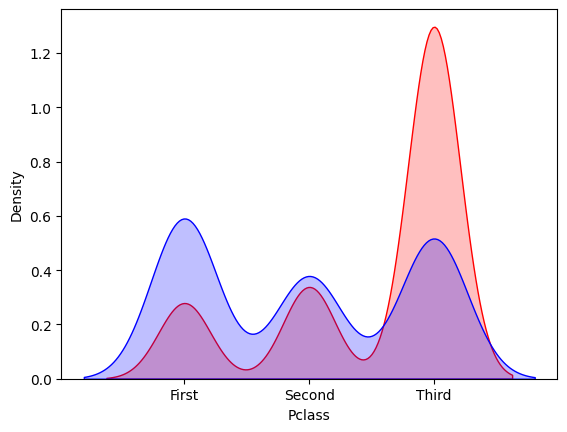

In [16]:
sns.kdeplot(transformed_train_set.loc[(transformed_train_set['Survived'] == 0),'Pclass'],shade=True,color='r',label='Not Survived')
ax=sns.kdeplot(transformed_train_set.loc[(transformed_train_set['Survived'] == 1),'Pclass'],shade=True,color='b',label='Survived' )

labels = ['First', 'Second', 'Third']
plt.xticks(sorted(transformed_train_set.Pclass.unique()),labels)

Clearly we can see that most of the people who lost their lives in the ttragedy were third class passengers.

Now one thig that bugs most people is that how the number of passengers in the third class is more than the second class passengers ! 
The answer lies in the numbers: there were way more passengers in the third class than in the second class.

Text(0, 0.5, 'Count')

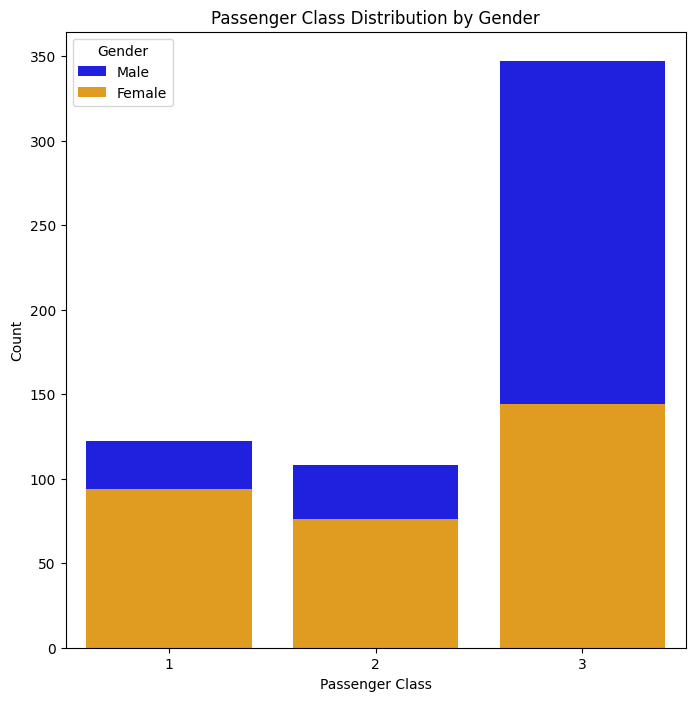

In [17]:

plt.subplots(figsize=(8, 8))

# Plot the count for males
sns.countplot(x='Pclass', data=transformed_train_set[transformed_train_set['Male'] == True], color='blue', label='Male')

# Plot the count for females
sns.countplot(x='Pclass', data=transformed_train_set[transformed_train_set['Female'] == True], color='orange', label='Female')

# Add legend and labels
plt.legend(title='Gender')
plt.title('Passenger Class Distribution by Gender')
plt.xlabel('Passenger Class')
plt.ylabel('Count')


**Interesting Visualization:**
In the first and second class most of the females survived, where as in the 3rd one the ratio of male and female survival is better than the other ones.

/tmp/ipykernel_42/949339681.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(transformed_train_set.loc[(transformed_train_set['Survived'] == 0),'Fare'],color='r',shade=True,label='Not Survived')
/tmp/ipykernel_42/949339681.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(transformed_train_set.loc[(transformed_train_set['Survived'] == 1),'Fare'],color='b',shade=True,label='Survived' )


Text(0.5, 1.0, 'How much to live')

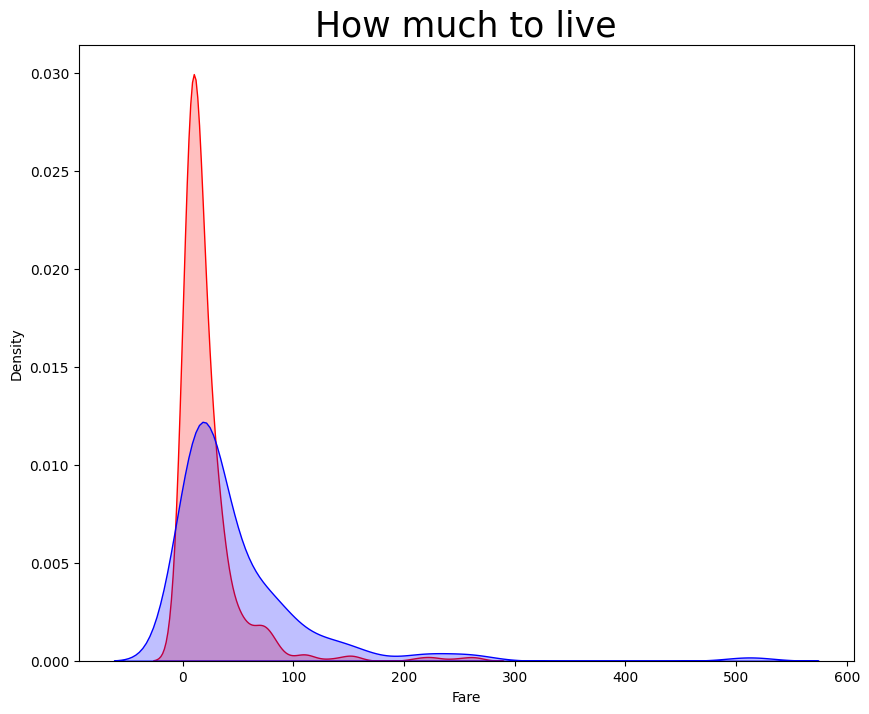

In [18]:
plt.subplots(figsize=(10,8))

ax=sns.kdeplot(transformed_train_set.loc[(transformed_train_set['Survived'] == 0),'Fare'],color='r',shade=True,label='Not Survived')
ax=sns.kdeplot(transformed_train_set.loc[(transformed_train_set['Survived'] == 1),'Fare'],color='b',shade=True,label='Survived' )
plt.title('How much to live',fontsize=25)

In [27]:
transformed_train_set.head()

,Survived,Pclass,Age,Fare,C,S,Q,Female,Male,FamilySize,isAlone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,22.0,7.2500,0.0,0.0,1.0,0.0,1.0,2,0,0.0,0.0,1.0,0.0,0.0
1,1,1,38.0,71.2833,1.0,0.0,0.0,1.0,0.0,2,0,0.0,0.0,0.0,1.0,0.0
2,1,3,26.0,7.9250,0.0,0.0,1.0,1.0,0.0,1,1,0.0,1.0,0.0,0.0,0.0
3,1,1,35.0,53.1000,0.0,0.0,1.0,1.0,0.0,2,0,0.0,0.0,0.0,1.0,0.0
4,0,3,35.0,8.0500,0.0,0.0,1.0,0.0,1.0,1,1,0.0,0.0,1.0,0.0,0.0


**Let us start preparing out ML Models**

In [28]:
from sklearn.preprocessing import StandardScaler

X= transformed_train_set.drop(['Survived'], axis=1)
y= transformed_train_set['Survived']

scaler= StandardScaler()
X_data=scaler.fit_transform(X)
y_data=y.to_numpy()

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    svm.SVC(probability=True),
    DecisionTreeClassifier(),
    XGBClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()]
    


In [30]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

SSplit= StratifiedShuffleSplit(test_size=0.2, random_state= 8)
acc_dict= {}

for train_index, test_index in SSplit.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for clf in classifiers:
        name= clf.__class__.__name__
        clf.fit(X_train,y_train)
        predict= clf.predict(X_test)
        acc = accuracy_score(y_test, predict)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] =acc

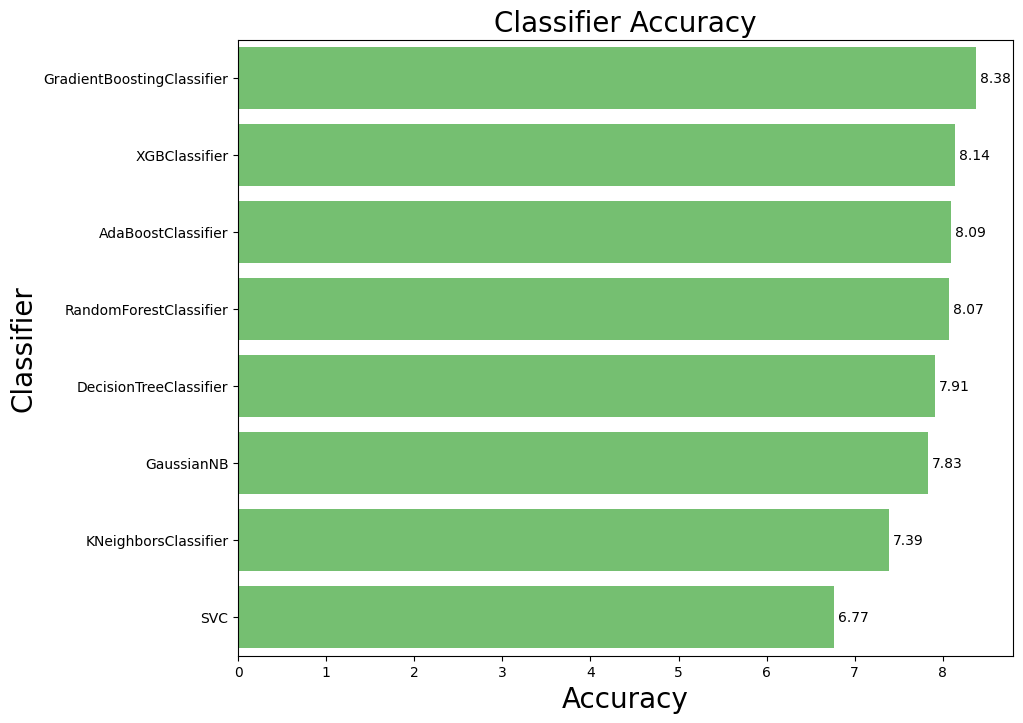

In [31]:
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(list(acc_dict.items()), columns= log_cols)
log.sort_values(by='Accuracy',ascending=False, inplace=True)
# Visualization
%matplotlib inline
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
ax = sns.barplot(y='Classifier', x='Accuracy', data=log, color='g')

# Add labels to each bar
ax.bar_label(ax.containers[0], fmt='%.2f', padding=3)

ax.set_xlabel('Accuracy', fontsize=20)
plt.ylabel('Classifier', fontsize=20)
plt.title('Classifier Accuracy', fontsize=20)
plt.show()

GradientBoostingClassifier and RandomForestClassifier are the two best performing models. Let us perform hyterparameter tuning on these models to see if we can improve the score.

In [32]:
from sklearn.model_selection import GridSearchCV
gb_param_grid = {
    'n_estimators': [100, 200, 300,500, 750],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 4, 5]
}

rf_param_grid = {
    'n_estimators': [100, 200, 300, 500, 750],
    'max_depth': [5,10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10]
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500, 750],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

gb_grid_search= GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv= 5, scoring="accuracy")
rf_grid_search= GridSearchCV(RandomForestClassifier(), rf_param_grid, cv= 5, scoring="accuracy")
xgb_grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                               xgb_param_grid, 
                               cv=5, 
                               scoring="accuracy",
                               n_jobs=-1) 

gb_grid_search.fit(X_train, y_train)
rf_grid_search.fit(X_train,y_train)
xgb_grid_search.fit(X_train, y_train)

print("Best parameters for Gradient Boosting: ", gb_grid_search.best_params_)
print("Best score for Gradient Boosting: ", gb_grid_search.best_score_)

print("Best parameters for Random Forest: ", rf_grid_search.best_params_)
print("Best score for Random Forest: ", rf_grid_search.best_score_)

print("Best parameters for XGBoost: ", xgb_grid_search.best_params_)
print("Best score for XGBoost: ", xgb_grid_search.best_score_)

Best parameters for Gradient Boosting:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best score for Gradient Boosting:  0.8468728454643948
Best parameters for Random Forest:  {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 500}
Best score for Random Forest:  0.8427262877967102
Best parameters for XGBoost:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.6}
Best score for XGBoost:  0.8525460455037919


So let us tune the models with the best parameters. 

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

# Define the models with the best parameters
gb_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=200)
rf_model = RandomForestClassifier(max_depth=30, min_samples_split=10, n_estimators=500)
xgb_model = XGBClassifier(colsample_bytree=0.7, learning_rate=0.1, max_depth=4, 
                          min_child_weight=3, n_estimators=100, subsample=0.6)

# Train the models
gb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Make predictions
gb_predictions = gb_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

# Calculate accuracy scores
gb_accuracy = accuracy_score(y_test, gb_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

print(f"Gradient Boosting Accuracy: {gb_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"XGBoost Accuracy: {xgb_accuracy}")



Gradient Boosting Accuracy: 0.7932960893854749
Random Forest Accuracy: 0.8268156424581006
XGBoost Accuracy: 0.8212290502793296


Now you can use the models seperately or you create a meta classifier, stacking all the models. 

In [35]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Meta-classifier
meta_classifier = AdaBoostClassifier()


# Stacking classifier
stack_clf = StackingClassifier(
    estimators=[
        ('gradient_boosting', gb_model),
        ('random_forest', rf_model),
        ('xgboost',xgb_model)
    ],
    final_estimator=meta_classifier
)

# Fit the stacking classifier on the training data
stack_clf.fit(X_train, y_train)

# Evaluate the stacking classifier
stack_accuracy = stack_clf.score(X_test, y_test)
print(f"Meta Classifier Accuracy: {stack_accuracy}")

Meta Classifier Accuracy: 0.8100558659217877


Now fitting the meta classifier on the complete data which was the transformed_train_set.

In [36]:
transformed_train_set
X_final= transformed_train_set.drop(['Survived'],axis=1)
y_final= transformed_train_set['Survived']

scaler= StandardScaler()
X_data_final= scaler.fit_transform(X_final)
y_data_final=y_final.to_numpy()

# traing the final data with the meta classifier that i have created
stack_clf.fit(X_data_final, y_data_final)




StackingClassifier(estimators=[('gradient_boosting',
                                GradientBoostingClassifier(n_estimators=200)),
                               ('random_forest',
                                RandomForestClassifier(max_depth=30,
                                                       min_samples_split=10,
                                                       n_estimators=500)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7, device=None,
                                              early_stoppi...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=3, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=AdaBoostClassifier())

In [37]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [38]:
final_test_data= pipeline.fit_transform(test_df)
final_test_data.head()

,Pclass,Age,Fare,C,S,Q,Female,Male,FamilySize,isAlone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,34.5,7.8292,0.0,1.0,0.0,0.0,1.0,1,1,0.0,0.0,1.0,0.0,0.0
1,3,47.0,7.0000,0.0,0.0,1.0,1.0,0.0,2,0,0.0,0.0,0.0,1.0,0.0
2,2,62.0,9.6875,0.0,1.0,0.0,0.0,1.0,1,1,0.0,0.0,1.0,0.0,0.0
3,3,27.0,8.6625,0.0,0.0,1.0,0.0,1.0,1,1,0.0,0.0,1.0,0.0,0.0
4,3,22.0,12.2875,0.0,0.0,1.0,1.0,0.0,3,0,0.0,0.0,0.0,1.0,0.0


In [45]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        418 non-null    int64  
 1   Age           418 non-null    float64
 2   Fare          417 non-null    float64
 3   C             418 non-null    float64
 4   S             418 non-null    float64
 5   Q             418 non-null    float64
 6   Female        418 non-null    float64
 7   Male          418 non-null    float64
 8   FamilySize    418 non-null    int64  
 9   isAlone       418 non-null    int64  
 10  Title_Master  418 non-null    float64
 11  Title_Miss    418 non-null    float64
 12  Title_Mr      418 non-null    float64
 13  Title_Mrs     418 non-null    float64
 14  Title_Rare    418 non-null    float64
dtypes: float64(12), int64(3)
memory usage: 49.1 KB


In [39]:
X_final_test_data= final_test_data.fillna(method="ffill")
scaler= StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test_data)


In [40]:
predictions= stack_clf.predict(X_data_final_test)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [44]:
final_df5 = pd.DataFrame(test_df['PassengerId'])
final_df5['Survived'] = predictions


# Specify the file path and name
file_path = '/kaggle/working/submission5.csv'

# Save the DataFrame to a CSV file
final_df5.to_csv(file_path, index=False)

# This line is for downloading the file when running the notebook interactively, like on Kaggle
# It will prompt you to download the file to your local machine
from IPython.display import FileLink
FileLink(file_path)


/kaggle/working/submission5.csv